In [ ]:
import scanpy as sc 
import numpy as np

res = sc.read_h5ad('lung_res_new_new.h5ad')

res_expression = res[:, :-32*32]

# Get slices for each sample_affect group
# Get slices for each sample_affect group
mf_slices = res_expression[res_expression.obs['sample_type'] == 'MF'].obs['slice_id'].unique()
lf_slices = res_expression[res_expression.obs['sample_type'] == 'LF'].obs['slice_id'].unique()


# Sample 10 random non-overlapping pairs within each group
np.random.seed(42)  # For reproducibility
mf_sampled = np.random.choice(mf_slices, size=5, replace=False)  # Need 20 total for 10 pairs
lf_sampled = np.random.choice(lf_slices, size=5, replace=False)

# Create list to store the sampled adata pairs
adata_pairs = []

print(mf_sampled.shape, lf_sampled.shape)

# Create 10 pairs within MF group
for i in range(0, 2):
    adata1_slice = res_expression[res_expression.obs['slice_id'] == mf_sampled[i]].copy()
    adata2_slice = res_expression[res_expression.obs['slice_id'] == mf_sampled[i+1]].copy() 
    adata_pairs.append((adata1_slice, adata2_slice))

# Create 10 pairs within LF group  
for i in range(0, 2):
    adata1_slice = res_expression[res_expression.obs['slice_id'] == lf_sampled[i]].copy()
    adata2_slice = res_expression[res_expression.obs['slice_id'] == lf_sampled[i+1]].copy()
    adata_pairs.append((adata1_slice, adata2_slice))

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/scSLAT_repo/lib/python3.11/site-packages/torch/cuda/__init__.py:56: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


(5,) (5,)


In [2]:
adata1, adata2 = adata_pairs[2]

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch

import scSLAT
from scSLAT.model import load_anndatas, Cal_Spatial_Net, run_SLAT, scanpy_workflow, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey, match_3D_celltype, Sankey
from scSLAT.metrics import region_statistics
from scSLAT.metrics import global_score, euclidean_dis, rotation_angle

# Fix random seeds for reproducibility
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


adata1, adata2 = adata_pairs[2]

Cal_Spatial_Net(adata1, k_cutoff=20, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=20, model='KNN')

edges, features = load_anndatas([adata1, adata2], feature='raw', check_order=False)

features = [torch.tensor(adata1.obsm['X_cellcharter_background']), torch.tensor(adata2.obsm['X_cellcharter_background'])]

embd0, embd1, time = run_SLAT(features, edges, LGCN_layer=5)

best, index, distance = spatial_match([embd0, embd1], reorder=False, adatas=[adata1,adata2])


matching = np.array([range(index.shape[0]), best])


Calculating spatial neighbor graph ...
The graph contains 793014 edges, 35502 cells.
22.337164103430794 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 995847 edges, 44367 cells.
22.445669078369058 neighbors per cell on average.
Use raw feature to format graph
Choose GPU:0 as device
Running
Training model time: 5.73


In [ ]:
adata1_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['CNiche']
                          })
adata2_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['CNiche']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()


# Create Sankey diagram showing flow between celltype and target_celltype
import plotly.graph_objects as go

adata2_df.to_csv('adata2_df_ct.csv')

# Get unique categories and counts
source_target_counts = adata2_df.groupby(['celltype', 'target_celltype']).size().reset_index()

# Create mappings for unique source and target categories 
source_categories = list(source_target_counts['celltype'].unique())
target_categories = list(source_target_counts['target_celltype'].unique())
category_to_id = {cat: i for i, cat in enumerate(source_categories)}
target_to_id = {cat: i+len(source_categories) for i, cat in enumerate(target_categories)}

# Create source, target and value lists
source = [category_to_id[x] for x in source_target_counts['celltype']]
target = [target_to_id[x] for x in source_target_counts['target_celltype']]
values = source_target_counts[0].tolist()

# Create node labels
node_labels = source_categories + target_categories

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = node_labels,
        color = "blue"
    ),
    link = dict(
        source = source,
        target = target,
        value = values
    )
)])

# Update layout
fig.update_layout(
    title_text="Cell Type Mapping Flow",
    font_size=10,
    height=800
)

fig.show()




In [ ]:
adata2_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['final_CT'],
                           'scores': distance[:,0],
                          'region': adata2.obs['CNiche']})

adata1_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['final_CT']
                          })



adata2_df.to_csv('adata2_df_fb.csv')

adata1_df.to_csv('adata1_df_fb.csv')

adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()

# Filter for region C4 and high confidence matches
#adata2_df = adata2_df[adata2_df['region'] == 'C4']
adata2_df = adata2_df[adata2_df['scores'] > 0.75]

# Filter for FBs in both source and target
filtered_df = adata2_df[
    (adata2_df['target_celltype'].apply(lambda x: 'FBs' in x)) &
    (adata2_df['celltype'].apply(lambda x: 'FBs' in x))
]

# Create Sankey diagram showing flow between target_celltype and celltype
import plotly.graph_objects as go
from collections import defaultdict

# Get unique categories and counts
source_target_counts = filtered_df.groupby(['target_celltype', 'celltype']).size().reset_index()

# Create mappings for unique source and target categories
source_categories = list(source_target_counts['target_celltype'].unique())
target_categories = list(source_target_counts['celltype'].unique())
category_to_id = {cat: i for i, cat in enumerate(source_categories)}
target_to_id = {cat: i+len(source_categories) for i, cat in enumerate(target_categories)}

# Create source, target and value lists
source = [category_to_id[x] for x in source_target_counts['target_celltype']]
target = [target_to_id[x] for x in source_target_counts['celltype']]
values = source_target_counts[0].tolist()

# Create node labels
node_labels = source_categories + target_categories

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = node_labels,
        color = "blue"
    ),
    link = dict(
        source = source,
        target = target,
        value = values
    )
)])

# Update layout
fig.update_layout(
    title_text="Fibroblast Cell Type Matching Flow",
    font_size=10,
    height=800
)

fig.show()


In [6]:
adata_2_test = adata2[adata2.obs['final_CT'] == 'Alveolar FBs'].copy()

adata2_matched = adata1[matching[1,:][(adata2.obs['final_CT'] == 'Alveolar FBs').values],:]

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/scSLAT_repo/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/scSLAT_repo/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/scSLAT_repo/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/scSLAT_repo/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



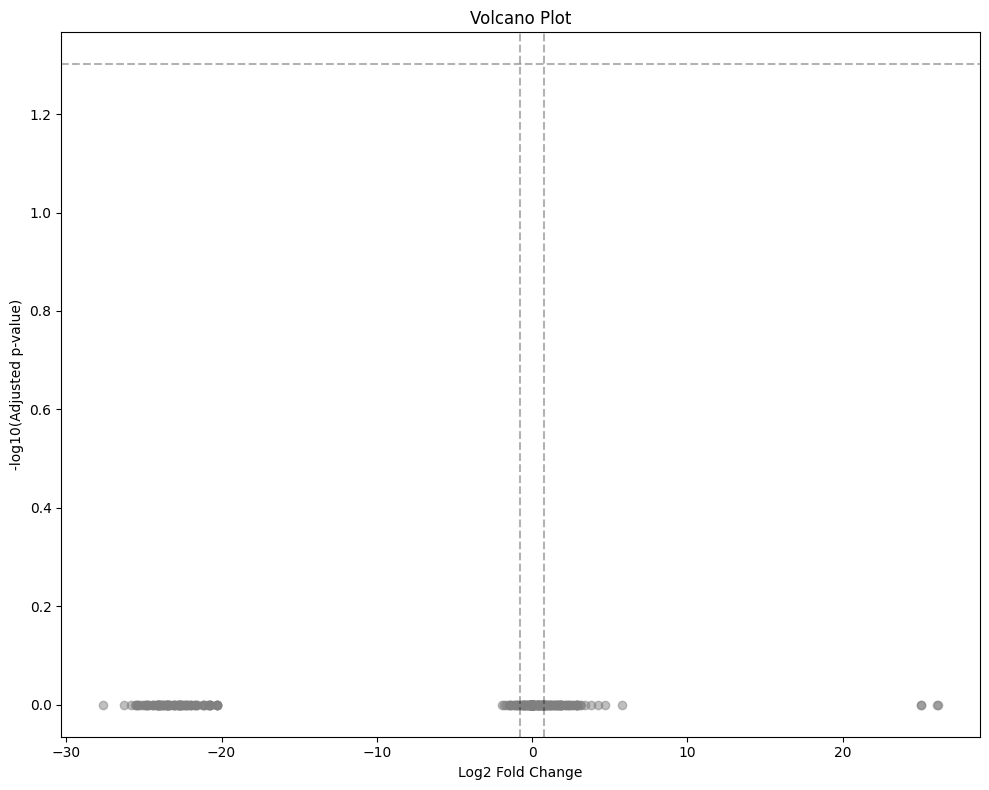

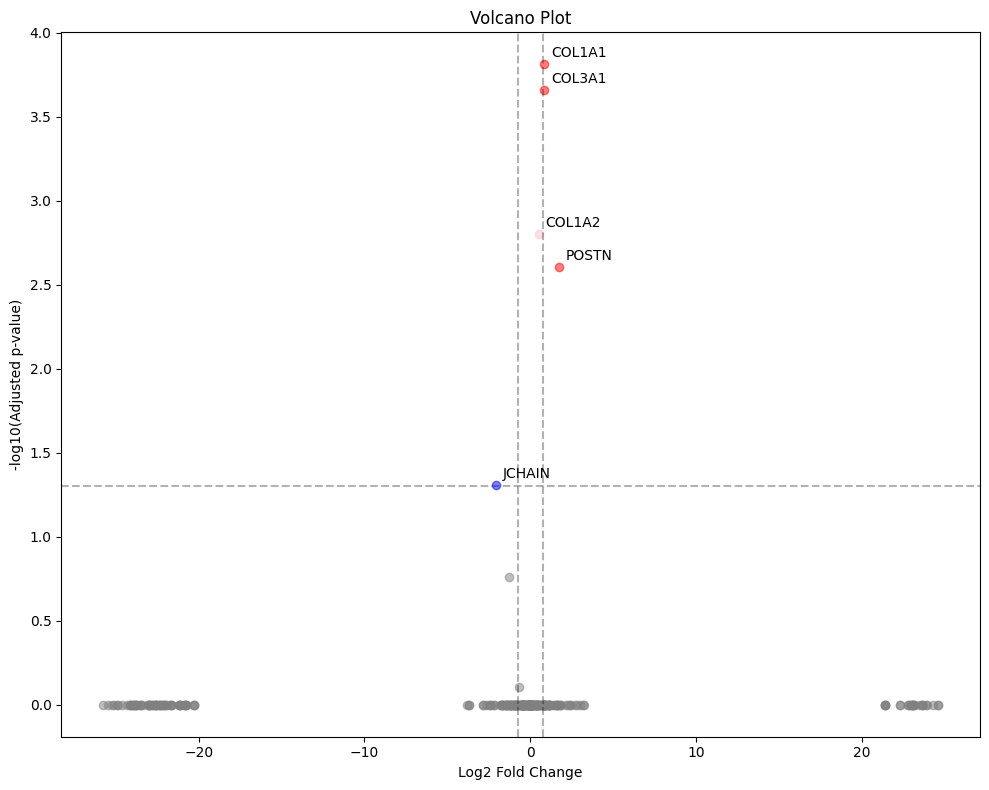

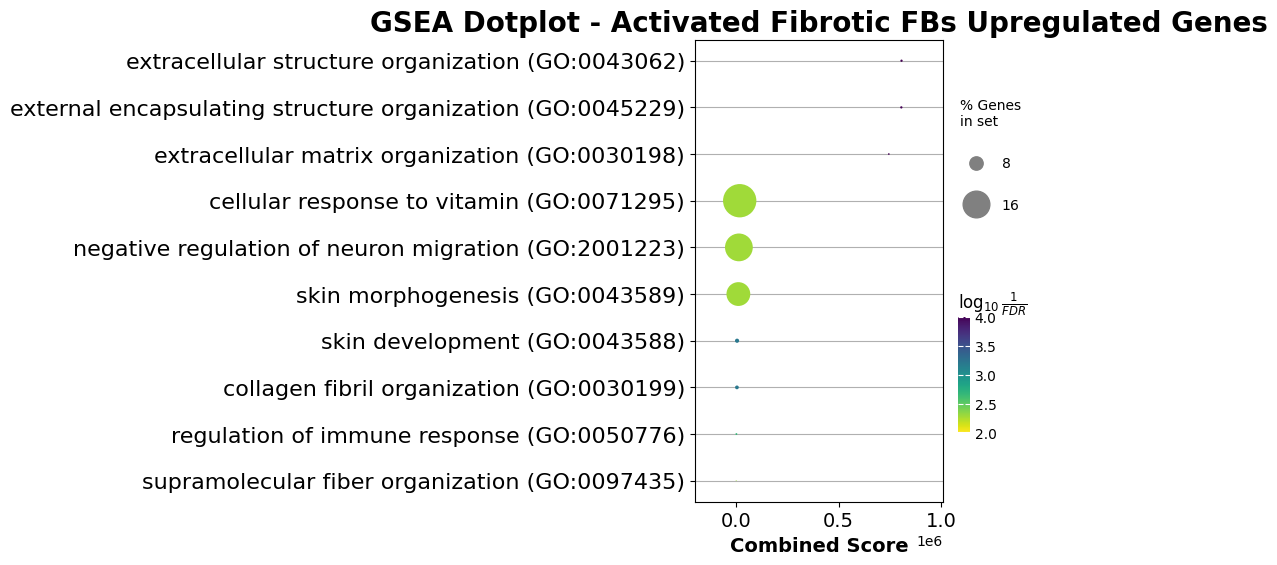

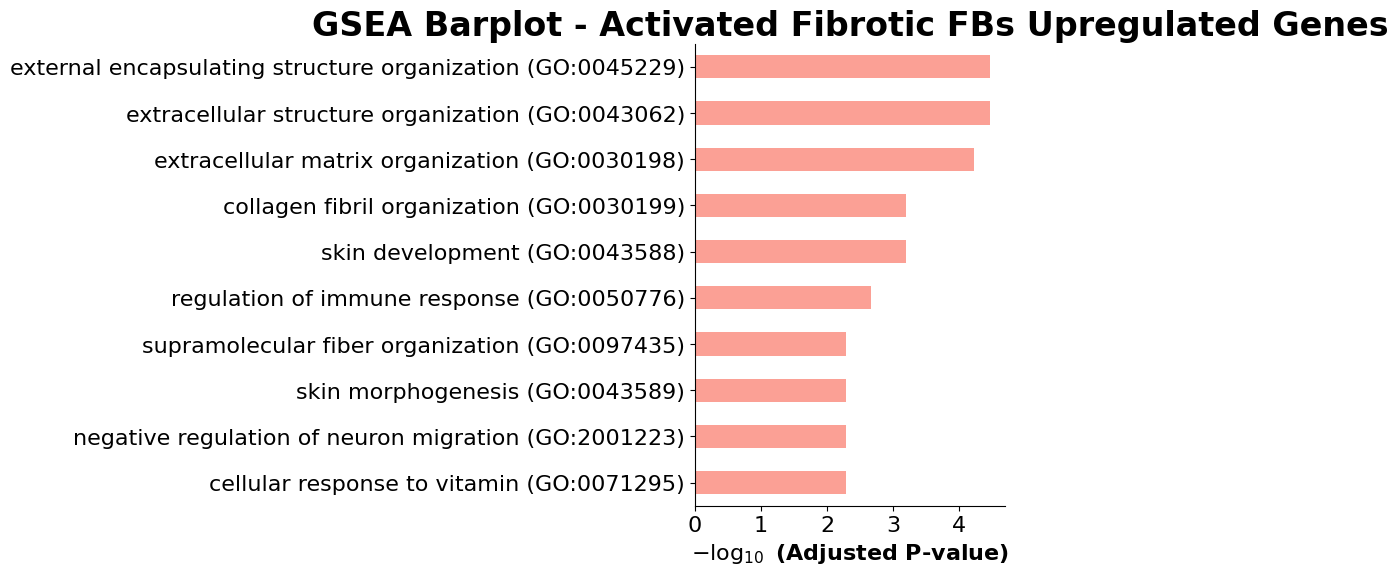

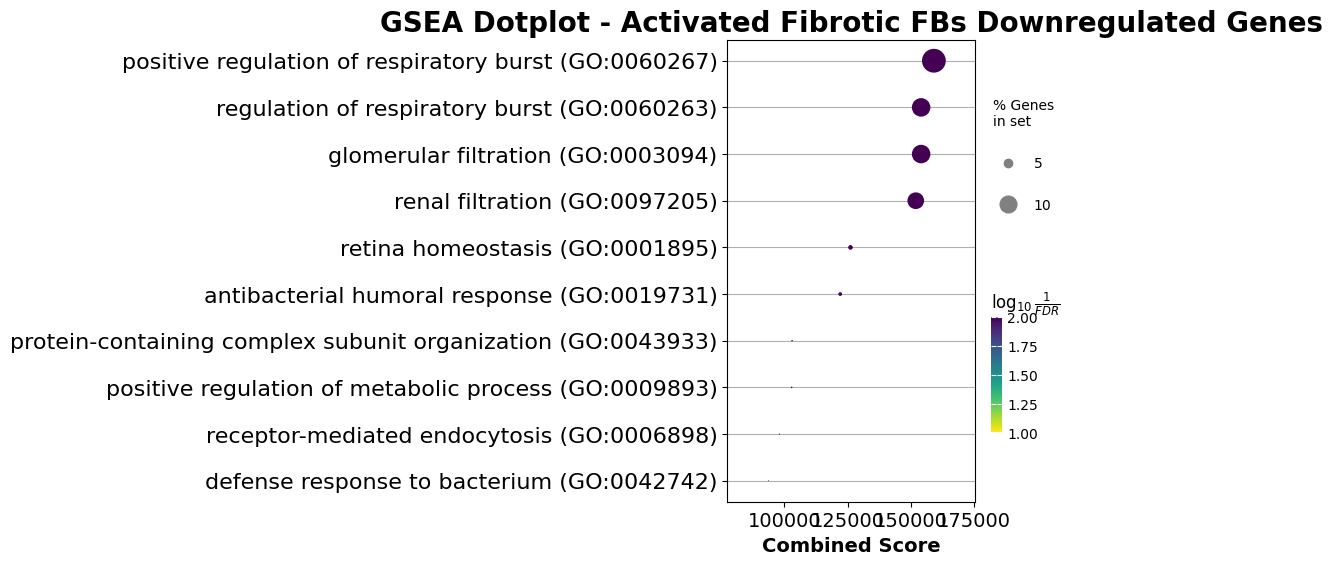

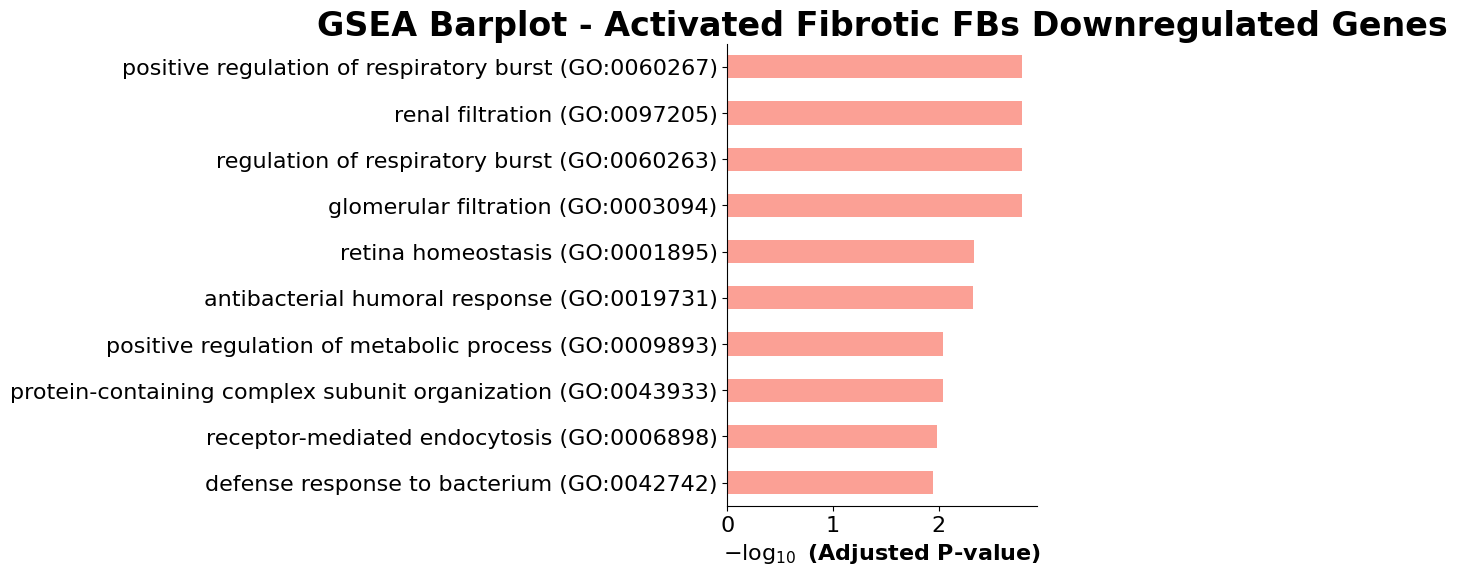

In [ ]:
# Get results from rank_genes_groups and create dataframe
import anndata as ad 
import scanpy as sc 
import numpy as np


adata1, adata2 = adata_pairs[2]

full_adata = adata1[matching[1,:]].copy()

full_adata.obs['targe_celltype'] = adata2.obs['final_CT'].values 

full_adata.obs['scores'] = distance[:,0]

full_adata = full_adata[full_adata.obs['scores'] > 0.8].copy()

full_adata = full_adata[full_adata.obs['final_CT'] == 'Alveolar FBs'].copy()

var_names = np.load('lung_gene_names.npy')

full_adata.var_names = var_names



full_adata = full_adata[full_adata.obs['targe_celltype'].isin(['Inflammatory FBs', 'Alveolar FBs', 'Activated Fibrotic FBs'])].copy()

sc.pp.normalize_total(full_adata)
sc.pp.log1p(full_adata)

sc.tl.rank_genes_groups(full_adata, groupby='targe_celltype', method='wilcoxon', reference='Alveolar FBs')

for cell in ['Inflammatory FBs', 'Activated Fibrotic FBs']:

    result = sc.get.rank_genes_groups_df(full_adata, group=cell)
    

    # Create volcano plot using matplotlib
    import matplotlib.pyplot as plt

    # Create figure
    plt.figure(figsize=(10, 8))

    # Plot non-significant points in gray
    non_significant = result['pvals_adj'] >= 0.05
    plt.scatter(result.loc[non_significant, 'logfoldchanges'],
            -np.log10(result.loc[non_significant, 'pvals_adj']),
            color='gray',
            alpha=0.5)

    # Plot significant points with |logFC| < 1 in light colors
    significant = result['pvals_adj'] < 0.05
    low_fc_up = (result['logfoldchanges'] < 0.75) & (result['logfoldchanges'] > 0) & significant
    low_fc_down = (result['logfoldchanges'] > -0.75) & (result['logfoldchanges'] < 0) & significant
    plt.scatter(result.loc[low_fc_up, 'logfoldchanges'],
            -np.log10(result.loc[low_fc_up, 'pvals_adj']),
            color='pink',
            alpha=0.5)
    plt.scatter(result.loc[low_fc_down, 'logfoldchanges'],
            -np.log10(result.loc[low_fc_down, 'pvals_adj']),
            color='lightblue',
            alpha=0.5)

    # Plot significant points with |logFC| >= 1 in dark colors
    high_fc_up = (result['logfoldchanges'] >= 0.75) & significant
    high_fc_down = (result['logfoldchanges'] <= -0.75) & significant
    plt.scatter(result.loc[high_fc_up, 'logfoldchanges'],
            -np.log10(result.loc[high_fc_up, 'pvals_adj']),
            color='red',
            alpha=0.5)
    plt.scatter(result.loc[high_fc_down, 'logfoldchanges'],
            -np.log10(result.loc[high_fc_down, 'pvals_adj']),
            color='blue',
            alpha=0.5)

    # Get top 5 genes by absolute fold change among significant genes
    result['abs_logfc'] = abs(result['logfoldchanges'])
    top_genes = result[significant].nlargest(5, 'abs_logfc')

    # Add labels for top genes
    for _, gene in top_genes.iterrows():
        plt.annotate(gene['names'],
                    xy=(gene['logfoldchanges'], -np.log10(gene['pvals_adj'])),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=10)

    # Add labels and title
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')
    plt.title('Volcano Plot')

    # Add horizontal line for p-value cutoff
    plt.axhline(y=-np.log10(0.05), color='k', linestyle='--', alpha=0.3)
    # Add vertical lines for fold change cutoffs
    plt.axvline(x=0.75, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=-0.75, color='k', linestyle='--', alpha=0.3)

    plt.tight_layout()

    plt.show()

    # Get upregulated and downregulated gene sets
    significant_genes = result[result['pvals_adj'] < 0.05]
    up_genes = significant_genes[significant_genes['logfoldchanges'] > 0.75]['names'].tolist()
    down_genes = significant_genes[significant_genes['logfoldchanges'] < -0.75]['names'].tolist()
        
        
    # Run enrichr analysis for both gene sets
    import gseapy as gp

    try:

        # Upregulated genes
        enr_up = gp.enrichr(gene_list=up_genes,
                            organism='Human',
                            gene_sets=['GO_Biological_Process_2021'])

        gp.dotplot(enr_up.res2d, title=f'GSEA Dotplot - {cell} Upregulated Genes',
                cutoff=0.1,
                color_bar_label='Normalized Enrichment Score (NES)',
                size=20)

        gp.barplot(enr_up.res2d, title=f'GSEA Barplot - {cell} Upregulated Genes',
                cutoff=0.1,
                color_bar_label='Normalized Enrichment Score (NES)')


    except:
        pass

    try:
        # Downregulated genes
        enr_down = gp.enrichr(gene_list=down_genes,
                            organism='Human', 
                            gene_sets=['GO_Biological_Process_2021'])

        gp.dotplot(enr_down.res2d, title=f'GSEA Dotplot - {cell} Downregulated Genes',
                cutoff=0.1,
                color_bar_label='Normalized Enrichment Score (NES)',
                size=20)

        gp.barplot(enr_down.res2d, title=f'GSEA Barplot - {cell} Downregulated Genes',
                cutoff=0.1,
                color_bar_label='Normalized Enrichment Score (NES)')
    
    except:
        pass



/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/scSLAT_repo/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/scSLAT_repo/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/scSLAT_repo/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



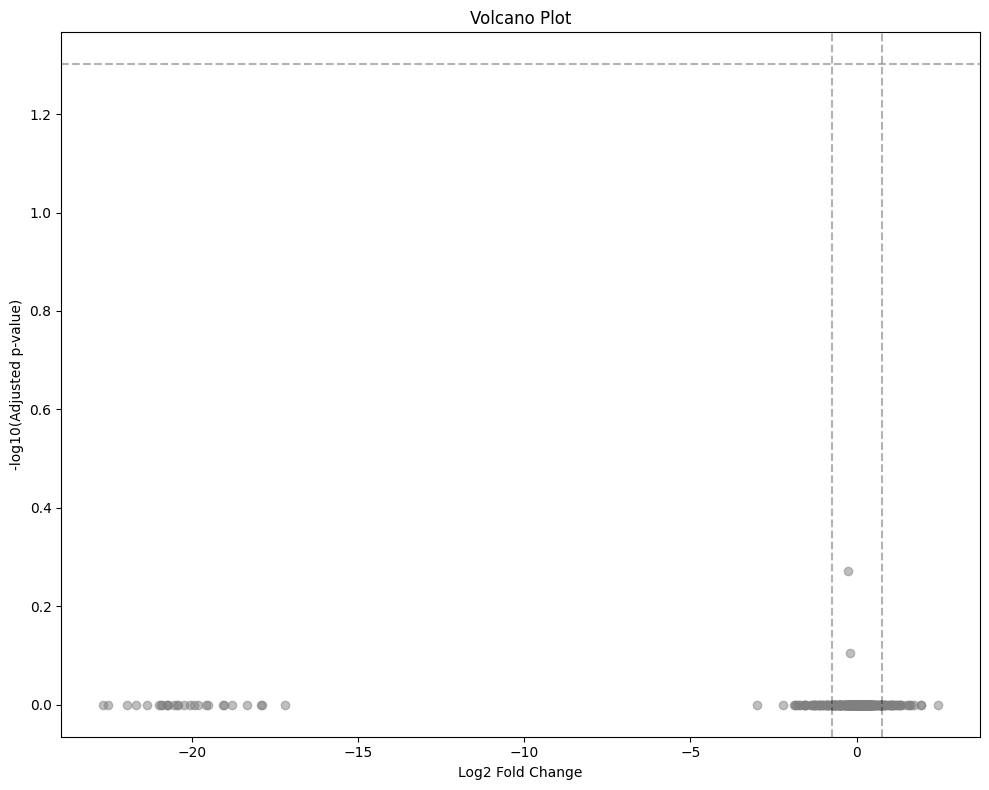

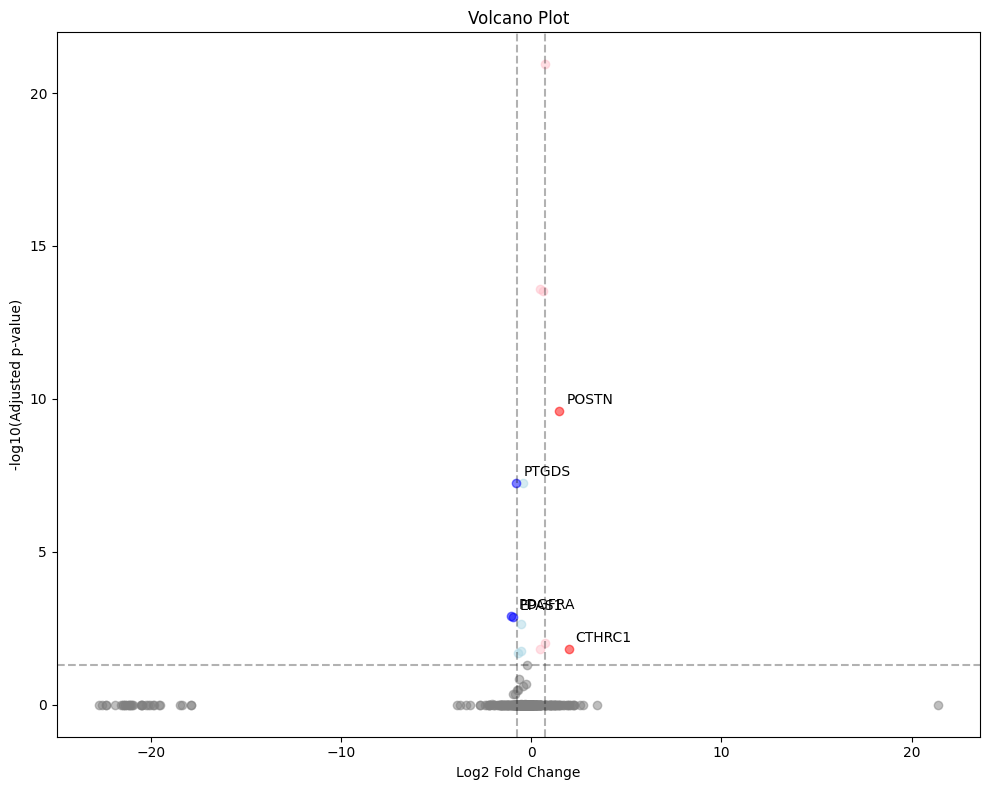

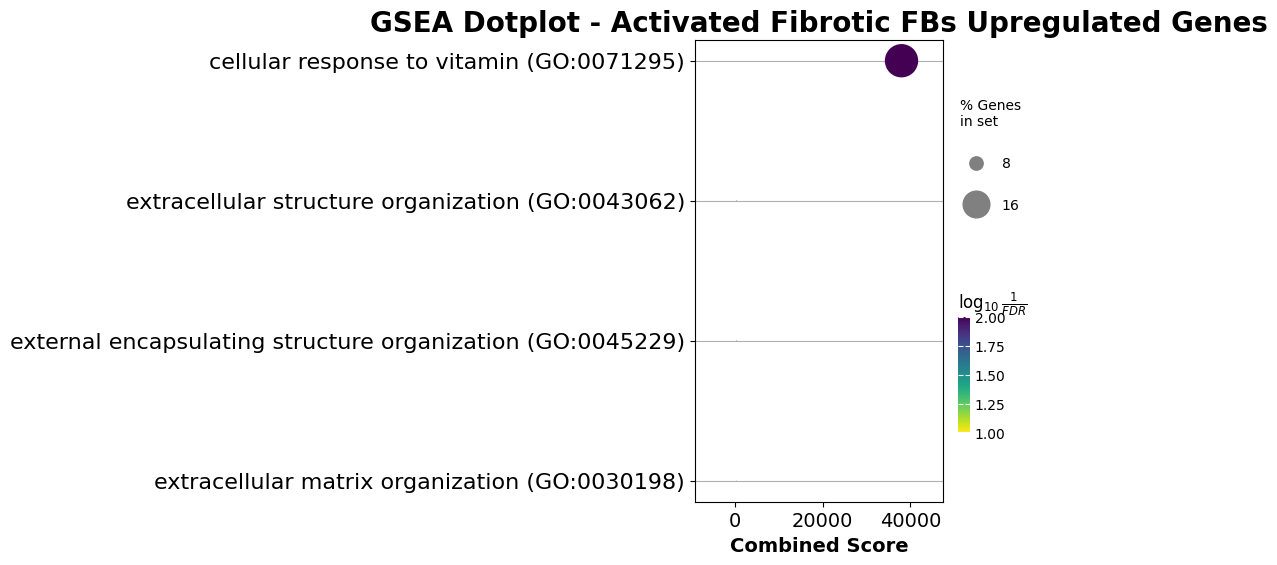

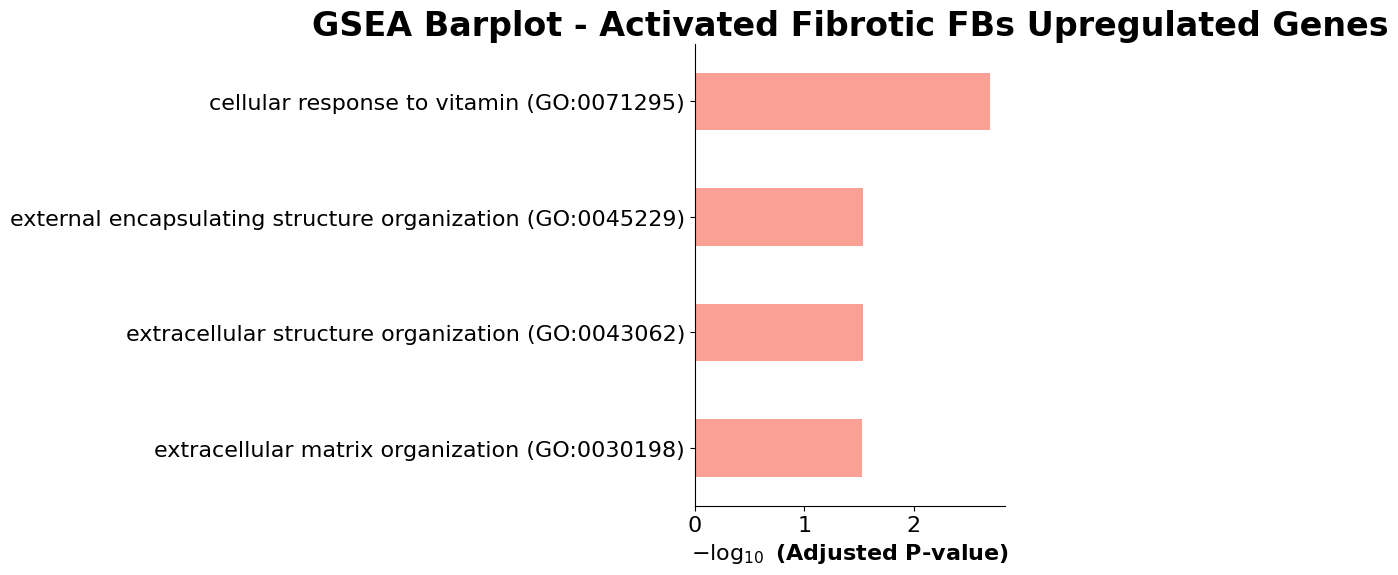

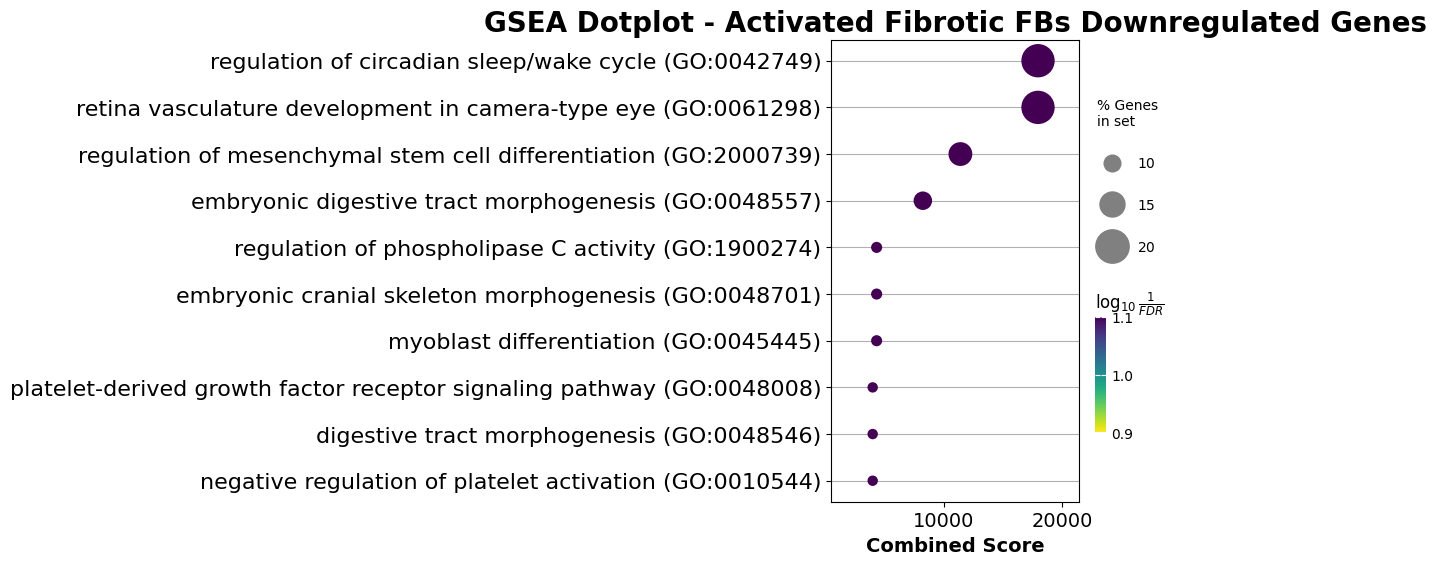

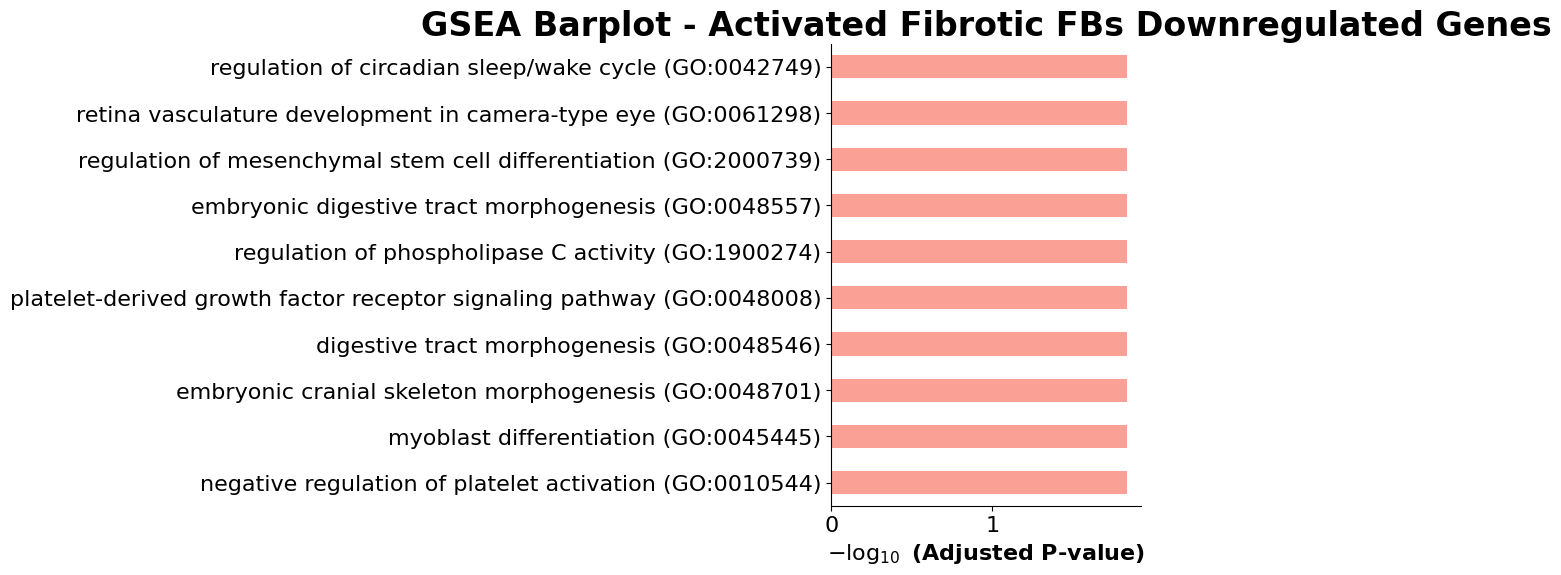

In [9]:
# Get results from rank_genes_groups and create dataframe
import anndata as ad 
import scanpy as sc 
import numpy as np


adata1, adata2 = adata_pairs[2]

full_adata = adata1[matching[1,:]].copy()

full_adata.obs['targe_celltype'] = adata2.obs['final_CT'].values 

full_adata = full_adata[full_adata.obs['final_CT'] == 'Alveolar FBs'].copy()

var_names = sc.read_h5ad('/lab/solexa_sun/lab_members/yancui/our_adata.h5ad').var_names.values

full_adata.var_names = var_names



full_adata = full_adata[full_adata.obs['targe_celltype'].isin(['Inflammatory FBs', 'Alveolar FBs', 'Activated Fibrotic FBs'])].copy()

sc.pp.normalize_total(full_adata)
sc.pp.log1p(full_adata)

sc.tl.rank_genes_groups(full_adata, groupby='targe_celltype', method='wilcoxon', reference='Alveolar FBs')

for cell in ['Inflammatory FBs', 'Activated Fibrotic FBs']:

    result = sc.get.rank_genes_groups_df(full_adata, group=cell)
    
    #result.to_csv(f'/lab/solexa_sun/lab_members/yancui/Haruka/lung_de_{cell}_res.csv')

    # Create volcano plot using matplotlib
    import matplotlib.pyplot as plt

    # Create figure
    plt.figure(figsize=(10, 8))

    # Plot non-significant points in gray
    non_significant = result['pvals_adj'] >= 0.05
    plt.scatter(result.loc[non_significant, 'logfoldchanges'],
            -np.log10(result.loc[non_significant, 'pvals_adj']),
            color='gray',
            alpha=0.5)

    # Plot significant points with |logFC| < 1 in light colors
    significant = result['pvals_adj'] < 0.05
    low_fc_up = (result['logfoldchanges'] < 0.75) & (result['logfoldchanges'] > 0) & significant
    low_fc_down = (result['logfoldchanges'] > -0.75) & (result['logfoldchanges'] < 0) & significant
    plt.scatter(result.loc[low_fc_up, 'logfoldchanges'],
            -np.log10(result.loc[low_fc_up, 'pvals_adj']),
            color='pink',
            alpha=0.5)
    plt.scatter(result.loc[low_fc_down, 'logfoldchanges'],
            -np.log10(result.loc[low_fc_down, 'pvals_adj']),
            color='lightblue',
            alpha=0.5)

    # Plot significant points with |logFC| >= 1 in dark colors
    high_fc_up = (result['logfoldchanges'] >= 0.75) & significant
    high_fc_down = (result['logfoldchanges'] <= -0.75) & significant
    plt.scatter(result.loc[high_fc_up, 'logfoldchanges'],
            -np.log10(result.loc[high_fc_up, 'pvals_adj']),
            color='red',
            alpha=0.5)
    plt.scatter(result.loc[high_fc_down, 'logfoldchanges'],
            -np.log10(result.loc[high_fc_down, 'pvals_adj']),
            color='blue',
            alpha=0.5)

    # Get top 5 genes by absolute fold change among significant genes
    result['abs_logfc'] = abs(result['logfoldchanges'])
    top_genes = result[significant].nlargest(5, 'abs_logfc')

    # Add labels for top genes
    for _, gene in top_genes.iterrows():
        plt.annotate(gene['names'],
                    xy=(gene['logfoldchanges'], -np.log10(gene['pvals_adj'])),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=10)

    # Add labels and title
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')
    plt.title('Volcano Plot')

    # Add horizontal line for p-value cutoff
    plt.axhline(y=-np.log10(0.05), color='k', linestyle='--', alpha=0.3)
    # Add vertical lines for fold change cutoffs
    plt.axvline(x=0.75, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=-0.75, color='k', linestyle='--', alpha=0.3)

    plt.tight_layout()
    #plt.savefig(f'/lab/solexa_sun/shared_Data/haruka_fig/lung_our_volcano_{cell}.pdf')
    plt.show()

    # Get upregulated and downregulated gene sets
    significant_genes = result[result['pvals_adj'] < 0.05]
    up_genes = significant_genes[significant_genes['logfoldchanges'] > 0.75]['names'].tolist()
    down_genes = significant_genes[significant_genes['logfoldchanges'] < -0.75]['names'].tolist()

    # Run enrichr analysis for both gene sets
    import gseapy as gp

    try:

        # Upregulated genes
        enr_up = gp.enrichr(gene_list=up_genes,
                            organism='Human',
                            gene_sets=['GO_Biological_Process_2021'])

        gp.dotplot(enr_up.res2d, title=f'GSEA Dotplot - {cell} Upregulated Genes',
                cutoff=0.1,
                color_bar_label='Normalized Enrichment Score (NES)',
                size=20)#.figure.savefig(f'/lab/solexa_sun/shared_Data/haruka_fig/lung_our_up_dotplot_{cell}.pdf')

        gp.barplot(enr_up.res2d, title=f'GSEA Barplot - {cell} Upregulated Genes',
                cutoff=0.1,
                color_bar_label='Normalized Enrichment Score (NES)')#.figure.savefig(f'/lab/solexa_sun/shared_Data/haruka_fig/lung_our_up_barplot_{cell}.pdf')


    except:
        pass

    try:
        # Downregulated genes
        enr_down = gp.enrichr(gene_list=down_genes,
                            organism='Human', 
                            gene_sets=['GO_Biological_Process_2021'])

        gp.dotplot(enr_down.res2d, title=f'GSEA Dotplot - {cell} Downregulated Genes',
                cutoff=0.1,
                color_bar_label='Normalized Enrichment Score (NES)',
                size=20)#.figure.savefig(f'/lab/solexa_sun/shared_Data/haruka_fig/lung_our_down_dotplot_{cell}.pdf')

        gp.barplot(enr_down.res2d, title=f'GSEA Barplot - {cell} Downregulated Genes',
                cutoff=0.1,
                color_bar_label='Normalized Enrichment Score (NES)')#.figure.savefig(f'/lab/solexa_sun/shared_Data/haruka_fig/lung_our_down_barplot_{cell}.pdf')
    
    except:
        pass

